In [0]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/'
base_dir = '/content/drive/My Drive/fastai-v3'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Detecting Indian Currency by using Transfer Learning

In [0]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 388.9MB 1.3MB/s eta 0:00:01

## Setup Input Pipeline

In [0]:
path_data = base_dir + '/Indian-Currency-Dataset/train'
path_test = base_dir + '/Indian-Currency-Dataset/test'
os.listdir(path_data)

In [0]:
path_data

In [0]:
IMAGE_SIZE = 448
BATCH_SIZE = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range = 90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    path_data,
    classes = ['none', '5', '10', '20', '50', '100', '200', '500', '2000'],
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

test_generator = test_datagen.flow_from_directory(path_test,
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                  batch_size=BATCH_SIZE)

In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((16, 448, 448, 3), (16, 9))

Save the labels in a file which will be downloaded later.

In [0]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open(path_data + '/labels.txt', 'w') as f:
  f.write(labels)

{'none': 0, '5': 1, '10': 2, '20': 3, '50': 4, '100': 5, '200': 6, '500': 7, '2000': 8}


In [0]:
!cat /content/drive/My\ Drive/fastai-v3/Indian-Currency-Dataset/train/labels.txt

10
100
20
200
2000
5
50
500
none

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = True

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 14, 14, 1280)      2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 2,626,953
Trainable params: 2,592,841
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 160


In [0]:
model.load_weights(path_data + '/save/fine_tuning/saved-weights-4.h5')

In [0]:
base_model.trainable = True

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 2,626,953
Trainable params: 2,592,841
Non-trainable params: 34,112
_________________________________________________________________


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 40

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40


W0826 02:46:22.880581 140524946667392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1412: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


15/32 [=============>................] - ETA: 23s - loss: 3.3174 - accuracy: 0.3115

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 59s 2s/step - loss: 2.4880 - accuracy: 0.4060 - val_loss: 2.6380 - val_accuracy: 0.2419
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 1.1003 - accuracy: 0.6640 - val_loss: 2.7692 - val_accuracy: 0.2988
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 1.0036 - accuracy: 0.6967 - val_loss: 3.7601 - val_accuracy: 0.2398
Epoch 4/40
32/32 [==============================] - 48s 1s/step - loss: 0.9877 - accuracy: 0.6866 - val_loss: 3.3568 - val_accuracy: 0.2907
Epoch 5/40
32/32 [==============================] - 48s 1s/step - loss: 0.8935 - accuracy: 0.7003 - val_loss: 3.6067 - val_accuracy: 0.2846
Epoch 6/40
32/32 [==============================] - 48s 1s/step - loss: 0.7914 - accuracy: 0.7421 - val_loss: 3.0105 - val_accuracy: 0.3191
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.9151 - accuracy: 0.7088 - val_loss: 1.8844 - val_accuracy: 0.3598
Epoch 8/40
32/32 [=============

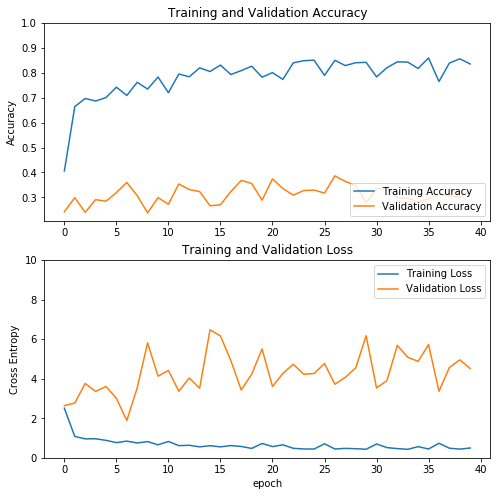

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
epochs = 40

history_1 = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.5543 - accuracy: 0.8525

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 58s 2s/step - loss: 0.5545 - accuracy: 0.8519 - val_loss: 4.2724 - val_accuracy: 0.3008
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.5564 - accuracy: 0.8428 - val_loss: 4.7080 - val_accuracy: 0.3171
Epoch 3/40
32/32 [==============================] - 49s 2s/step - loss: 0.4311 - accuracy: 0.8655 - val_loss: 5.3580 - val_accuracy: 0.2947
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.4088 - accuracy: 0.8705 - val_loss: 4.1000 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 49s 2s/step - loss: 0.3656 - accuracy: 0.8927 - val_loss: 5.6942 - val_accuracy: 0.3130
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.4129 - accuracy: 0.8670 - val_loss: 5.0287 - val_accuracy: 0.3130
Epoch 7/40
32/32 [==============================] - 48s 1s/step - loss: 0.3456 - accuracy: 0.8877 - val_loss: 4.8635 - val_accuracy: 0.3354
Epoch 8/40
32/32 [=============

In [0]:
model.save(path_data + '/save/fine_tuning/stage-2.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/save-weights-2.h5')

### Un-freeze the top layers of the model


In [0]:
# model.layers[0].trainable = True
# # base_model.trainable = False
# # model.load_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 3

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 14, 14, 1280)      2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 297       
Total params: 2,626,953
Trainable params: 2,591,977
Non-trainable params: 34,976
_________________________________________________________________


In [0]:
# model.load_weights(path_data + '/save/fine_tuning/saved-weights-13.h5')

In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


### Continue Train the model

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=10,
                         validation_data=val_generator)

Epoch 1/10


W0826 07:51:13.835215 139796592494464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1412: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


 4/32 [==>...........................] - ETA: 50s - loss: 0.2006 - accuracy: 0.9297

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 63s 2s/step - loss: 0.3476 - accuracy: 0.9325 - val_loss: 6.0844 - val_accuracy: 0.2988
Epoch 2/10
32/32 [==============================] - 52s 2s/step - loss: 0.1839 - accuracy: 0.9431 - val_loss: 5.6400 - val_accuracy: 0.3211
Epoch 3/10
32/32 [==============================] - 51s 2s/step - loss: 0.1719 - accuracy: 0.9451 - val_loss: 5.9036 - val_accuracy: 0.3130
Epoch 4/10
32/32 [==============================] - 53s 2s/step - loss: 0.2667 - accuracy: 0.9511 - val_loss: 5.4345 - val_accuracy: 0.3150
Epoch 5/10
32/32 [==============================] - 51s 2s/step - loss: 0.2124 - accuracy: 0.9461 - val_loss: 5.4808 - val_accuracy: 0.3008
Epoch 6/10
32/32 [==============================] - 52s 2s/step - loss: 0.2404 - accuracy: 0.9481 - val_loss: 5.1721 - val_accuracy: 0.3171
Epoch 7/10
32/32 [==============================] - 53s 2s/step - loss: 0.1784 - accuracy: 0.9476 - val_loss: 5.3572 - val_accuracy: 0.3110
Epoch 8/10
32/32 [=============

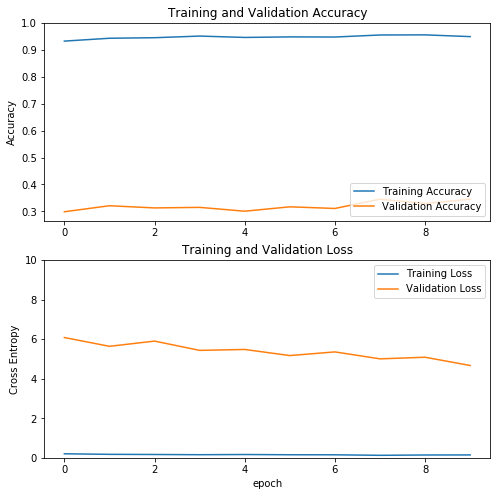

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 62s 2s/step - loss: 0.1356 - accuracy: 0.9531 - val_loss: 4.3853 - val_accuracy: 0.3537
Epoch 2/40
32/32 [==============================] - 52s 2s/step - loss: 0.1964 - accuracy: 0.9552 - val_loss: 4.7589 - val_accuracy: 0.3455
Epoch 3/40
32/32 [==============================] - 52s 2s/step - loss: 0.2821 - accuracy: 0.9587 - val_loss: 4.7894 - val_accuracy: 0.3313
Epoch 4/40
32/32 [==============================] - 51s 2s/step - loss: 0.1591 - accuracy: 0.9537 - val_loss: 4.8862 - val_accuracy: 0.3516
Epoch 5/40
32/32 [==============================] - 51s 2s/step - loss: 0.2668 - accuracy: 0.9516 - val_loss: 5.0605 - val_accuracy: 0.3455
Epoch 6/40
32/32 [==============================] - 51s 2s/step - loss: 0.2290 - accuracy: 0.9531 - val_loss: 4.8269 - val_accuracy: 0.3435
Epoch 7/40
32/32 [==============================] - 50s 2s/step - loss: 0.3032 - accuracy: 0.9466 - val_loss: 4.8531 - val_accuracy: 0.3537
Epoch 8/40
32/32 [=============

In [0]:
# model.save(path_data + '/save/fine_tuning/stage-3.h5')

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-5.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 60s 2s/step - loss: 0.1728 - accuracy: 0.9743 - val_loss: 3.9873 - val_accuracy: 0.3720
Epoch 2/40
32/32 [==============================] - 51s 2s/step - loss: 0.2016 - accuracy: 0.9688 - val_loss: 3.8554 - val_accuracy: 0.3537
Epoch 3/40
32/32 [==============================] - 51s 2s/step - loss: 0.1394 - accuracy: 0.9683 - val_loss: 3.6316 - val_accuracy: 0.3862
Epoch 4/40
32/32 [==============================] - 51s 2s/step - loss: 0.1450 - accuracy: 0.9668 - val_loss: 3.7769 - val_accuracy: 0.3679
Epoch 5/40
32/32 [==============================] - 51s 2s/step - loss: 0.0881 - accuracy: 0.9758 - val_loss: 3.8519 - val_accuracy: 0.3943
Epoch 6/40
32/32 [==============================] - 51s 2s/step - loss: 0.1896 - accuracy: 0.9753 - val_loss: 3.9814 - val_accuracy: 0.3476
Epoch 7/40
32/32 [==============================] - 51s 2s/step - loss: 0.1219 - accuracy: 0.9698 - val_loss: 3.8816 - val_accuracy: 0.3760
Epoch 8/40
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-6.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40
 3/32 [=>............................] - ETA: 53s - loss: 0.0505 - accuracy: 0.9948 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 61s 2s/step - loss: 0.1449 - accuracy: 0.9819 - val_loss: 3.6129 - val_accuracy: 0.3963
Epoch 2/40
32/32 [==============================] - 51s 2s/step - loss: 0.0574 - accuracy: 0.9829 - val_loss: 3.5820 - val_accuracy: 0.4126
Epoch 3/40
32/32 [==============================] - 52s 2s/step - loss: 0.0880 - accuracy: 0.9778 - val_loss: 3.5486 - val_accuracy: 0.4045
Epoch 4/40
32/32 [==============================] - 51s 2s/step - loss: 0.0707 - accuracy: 0.9834 - val_loss: 3.6161 - val_accuracy: 0.4065
Epoch 5/40
32/32 [==============================] - 52s 2s/step - loss: 0.0787 - accuracy: 0.9824 - val_loss: 3.5690 - val_accuracy: 0.3923
Epoch 6/40
32/32 [==============================] - 51s 2s/step - loss: 0.0822 - accuracy: 0.9839 - val_loss: 3.5742 - val_accuracy: 0.3862
Epoch 7/40
32/32 [==============================] - 50s 2s/step - loss: 0.0689 - accuracy: 0.9854 - val_loss: 3.7343 - val_accuracy: 0.3902
Epoch 8/40
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-7.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40
30/32 [===========================>..] - ETA: 2s - loss: 0.1119 - accuracy: 0.9871

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 60s 2s/step - loss: 0.1049 - accuracy: 0.9874 - val_loss: 3.1861 - val_accuracy: 0.4126
Epoch 2/40
32/32 [==============================] - 51s 2s/step - loss: 0.1002 - accuracy: 0.9793 - val_loss: 3.1733 - val_accuracy: 0.4167
Epoch 3/40
32/32 [==============================] - 48s 2s/step - loss: 0.0833 - accuracy: 0.9864 - val_loss: 3.2047 - val_accuracy: 0.4045
Epoch 4/40
32/32 [==============================] - 49s 2s/step - loss: 0.0632 - accuracy: 0.9829 - val_loss: 3.0042 - val_accuracy: 0.4309
Epoch 5/40
32/32 [==============================] - 48s 2s/step - loss: 0.3165 - accuracy: 0.9859 - val_loss: 3.1856 - val_accuracy: 0.4106
Epoch 6/40
32/32 [==============================] - 48s 2s/step - loss: 0.0701 - accuracy: 0.9869 - val_loss: 3.1674 - val_accuracy: 0.4024
Epoch 7/40
32/32 [==============================] - 49s 2s/step - loss: 0.1055 - accuracy: 0.9864 - val_loss: 3.1243 - val_accuracy: 0.4004
Epoch 8/40
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-8.h5')

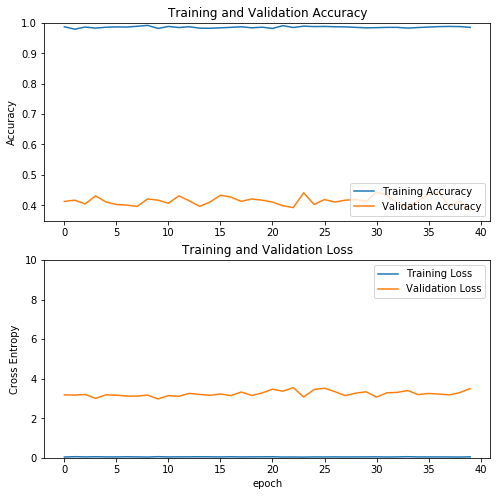

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.load_weights(path_data + '/save/fine_tuning/saved-weights-8.h5')

In [0]:
history_fine = model.fit_generator(train_generator, 
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40
20/32 [=================>............] - ETA: 15s - loss: 0.0734 - accuracy: 0.9803

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 59s 2s/step - loss: 0.0687 - accuracy: 0.9798 - val_loss: 3.9147 - val_accuracy: 0.4126
Epoch 2/40
32/32 [==============================] - 49s 2s/step - loss: 0.0962 - accuracy: 0.9743 - val_loss: 3.4678 - val_accuracy: 0.4451
Epoch 3/40
32/32 [==============================] - 51s 2s/step - loss: 0.1120 - accuracy: 0.9763 - val_loss: 3.7434 - val_accuracy: 0.4268
Epoch 4/40
32/32 [==============================] - 51s 2s/step - loss: 0.0530 - accuracy: 0.9829 - val_loss: 3.6662 - val_accuracy: 0.4167
Epoch 5/40
32/32 [==============================] - 52s 2s/step - loss: 0.0532 - accuracy: 0.9879 - val_loss: 3.4396 - val_accuracy: 0.4207
Epoch 6/40
32/32 [==============================] - 51s 2s/step - loss: 0.0418 - accuracy: 0.9844 - val_loss: 3.4323 - val_accuracy: 0.4309
Epoch 7/40
32/32 [==============================] - 51s 2s/step - loss: 0.0920 - accuracy: 0.9854 - val_loss: 3.4859 - val_accuracy: 0.4492
Epoch 8/40
32/32 [=============

In [0]:
#BEST TILL NOW
model.save_weights(path_data + '/save/fine_tuning/saved-weights-9.h5')

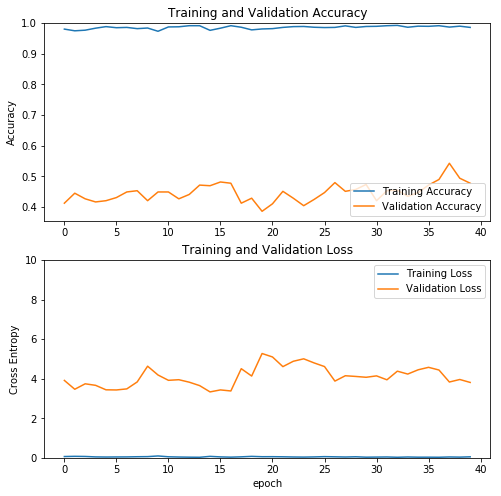

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.layers[0].trainable = False

In [0]:
model.layers[0].trainable

False

In [0]:
base_model.trainable

False

In [0]:
 base_model.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
epochs = 10

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

Epoch 1/10
20/32 [=================>............] - ETA: 15s - loss: 0.0612 - accuracy: 0.9910

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 62s 2s/step - loss: 0.0484 - accuracy: 0.9904 - val_loss: 4.1912 - val_accuracy: 0.4533
Epoch 2/10
32/32 [==============================] - 51s 2s/step - loss: 0.3028 - accuracy: 0.9834 - val_loss: 3.9698 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 50s 2s/step - loss: 0.1189 - accuracy: 0.9819 - val_loss: 3.6468 - val_accuracy: 0.4715
Epoch 4/10
32/32 [==============================] - 50s 2s/step - loss: 0.0783 - accuracy: 0.9909 - val_loss: 4.6973 - val_accuracy: 0.4715
Epoch 5/10
32/32 [==============================] - 50s 2s/step - loss: 0.0582 - accuracy: 0.9859 - val_loss: 4.9428 - val_accuracy: 0.4695
Epoch 6/10
32/32 [==============================] - 50s 2s/step - loss: 0.3374 - accuracy: 0.9778 - val_loss: 3.8595 - val_accuracy: 0.4533
Epoch 7/10
32/32 [==============================] - 50s 2s/step - loss: 0.2250 - accuracy: 0.9758 - val_loss: 3.6738 - val_accuracy: 0.4797
Epoch 8/10
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-9-freeze.h5')

In [0]:
model.layers[0].trainable = False
model.load_weights(path_data + '/save/fine_tuning/saved-weights-9-freeze.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs=80,
                         validation_data=val_generator)

Epoch 1/80


W0826 14:18:04.180350 140078018992000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1412: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


27/32 [========================>.....] - ETA: 2:46 - loss: 0.1813 - accuracy: 0.9952

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 1317s 41s/step - loss: 0.1530 - accuracy: 0.9945 - val_loss: 3.3417 - val_accuracy: 0.4817
Epoch 2/80
32/32 [==============================] - 55s 2s/step - loss: 0.0415 - accuracy: 0.9929 - val_loss: 3.5905 - val_accuracy: 0.4817
Epoch 3/80
32/32 [==============================] - 58s 2s/step - loss: 0.0996 - accuracy: 0.9924 - val_loss: 3.5909 - val_accuracy: 0.4939
Epoch 4/80
32/32 [==============================] - 58s 2s/step - loss: 0.2198 - accuracy: 0.9899 - val_loss: 3.9699 - val_accuracy: 0.4573
Epoch 5/80
32/32 [==============================] - 58s 2s/step - loss: 0.1425 - accuracy: 0.9874 - val_loss: 4.0345 - val_accuracy: 0.4776
Epoch 6/80
32/32 [==============================] - 58s 2s/step - loss: 0.1025 - accuracy: 0.9854 - val_loss: 3.8981 - val_accuracy: 0.4858
Epoch 7/80
32/32 [==============================] - 57s 2s/step - loss: 0.0728 - accuracy: 0.9960 - val_loss: 3.9595 - val_accuracy: 0.4776
Epoch 8/80
32/32 [==========

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

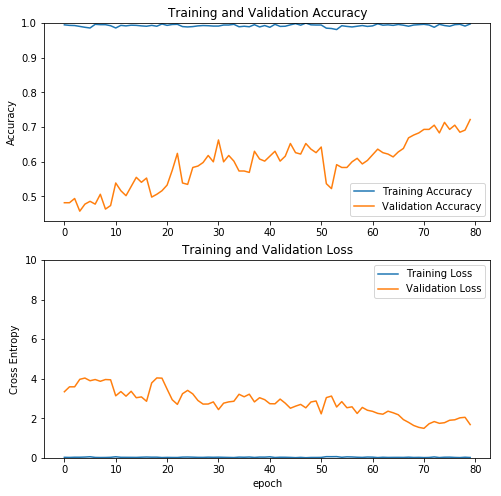

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40
27/32 [========================>.....] - ETA: 8s - loss: 0.0119 - accuracy: 0.9965 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 83s 3s/step - loss: 0.1233 - accuracy: 0.9965 - val_loss: 1.4402 - val_accuracy: 0.7256
Epoch 2/40
32/32 [==============================] - 59s 2s/step - loss: 0.1470 - accuracy: 0.9879 - val_loss: 1.6591 - val_accuracy: 0.7175
Epoch 3/40
32/32 [==============================] - 61s 2s/step - loss: 0.1615 - accuracy: 0.9914 - val_loss: 1.9557 - val_accuracy: 0.6931
Epoch 4/40
32/32 [==============================] - 60s 2s/step - loss: 0.1053 - accuracy: 0.9914 - val_loss: 2.1011 - val_accuracy: 0.6911
Epoch 5/40
32/32 [==============================] - 60s 2s/step - loss: 0.0277 - accuracy: 0.9955 - val_loss: 2.0926 - val_accuracy: 0.6890
Epoch 6/40
32/32 [==============================] - 60s 2s/step - loss: 0.0403 - accuracy: 0.9945 - val_loss: 2.0378 - val_accuracy: 0.7093
Epoch 7/40
32/32 [==============================] - 61s 2s/step - loss: 0.0633 - accuracy: 0.9940 - val_loss: 2.0222 - val_accuracy: 0.7033
Epoch 8/40
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-10.h5')

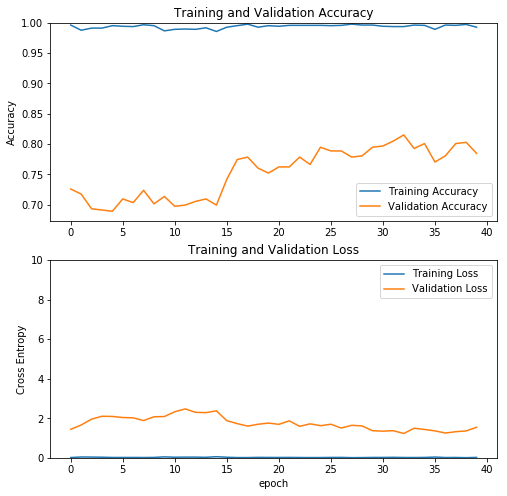

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40


W0827 04:33:46.310989 140433794697088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1412: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


12/32 [==========>...................] - ETA: 11:09 - loss: 0.0288 - accuracy: 0.9896

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 1245s 39s/step - loss: 0.0659 - accuracy: 0.9940 - val_loss: 1.6635 - val_accuracy: 0.7642
Epoch 2/40
32/32 [==============================] - 53s 2s/step - loss: 0.0287 - accuracy: 0.9970 - val_loss: 1.4978 - val_accuracy: 0.7642
Epoch 3/40
32/32 [==============================] - 55s 2s/step - loss: 0.0415 - accuracy: 0.9970 - val_loss: 1.5927 - val_accuracy: 0.7785
Epoch 4/40
32/32 [==============================] - 54s 2s/step - loss: 0.1050 - accuracy: 0.9960 - val_loss: 1.6671 - val_accuracy: 0.7907
Epoch 5/40
32/32 [==============================] - 54s 2s/step - loss: 0.0453 - accuracy: 0.9975 - val_loss: 1.6332 - val_accuracy: 0.7785
Epoch 6/40
32/32 [==============================] - 54s 2s/step - loss: 0.0533 - accuracy: 0.9980 - val_loss: 1.4091 - val_accuracy: 0.7907
Epoch 7/40
32/32 [==============================] - 54s 2s/step - loss: 0.0324 - accuracy: 0.9980 - val_loss: 1.6859 - val_accuracy: 0.7642
Epoch 8/40
32/32 [==========

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-11.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40
22/32 [===================>..........] - ETA: 14s - loss: 0.0971 - accuracy: 0.9978

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 62s 2s/step - loss: 0.0655 - accuracy: 0.9985 - val_loss: 1.2700 - val_accuracy: 0.7988
Epoch 2/40
32/32 [==============================] - 53s 2s/step - loss: 0.0246 - accuracy: 0.9980 - val_loss: 1.5033 - val_accuracy: 0.7622
Epoch 3/40
32/32 [==============================] - 53s 2s/step - loss: 0.2203 - accuracy: 0.9904 - val_loss: 1.3281 - val_accuracy: 0.8008
Epoch 4/40
32/32 [==============================] - 53s 2s/step - loss: 0.1000 - accuracy: 0.9960 - val_loss: 1.7688 - val_accuracy: 0.7602
Epoch 5/40
32/32 [==============================] - 53s 2s/step - loss: 0.0676 - accuracy: 0.9985 - val_loss: 1.6976 - val_accuracy: 0.7907
Epoch 6/40
32/32 [==============================] - 53s 2s/step - loss: 0.0294 - accuracy: 0.9965 - val_loss: 1.5139 - val_accuracy: 0.7764
Epoch 7/40
32/32 [==============================] - 52s 2s/step - loss: 0.0560 - accuracy: 0.9955 - val_loss: 1.5012 - val_accuracy: 0.7988
Epoch 8/40
32/32 [=============

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-12.h5')

In [0]:
history_fine = model.fit_generator(train_generator,
                         epochs=40,
                         validation_data=val_generator)

Epoch 1/40


W0827 11:50:26.217467 140473515624320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1412: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


101/125 [=======================>......] - ETA: 28s - loss: 0.1742 - accuracy: 0.9455

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


125/125 [==============================] - 178s 1s/step - loss: 0.2050 - accuracy: 0.9426 - val_loss: 1.3517 - val_accuracy: 0.6443
Epoch 2/40
125/125 [==============================] - 167s 1s/step - loss: 0.1061 - accuracy: 0.9728 - val_loss: 1.2275 - val_accuracy: 0.6992
Epoch 3/40
125/125 [==============================] - 167s 1s/step - loss: 0.0662 - accuracy: 0.9829 - val_loss: 1.7123 - val_accuracy: 0.6606
Epoch 4/40
125/125 [==============================] - 169s 1s/step - loss: 0.0638 - accuracy: 0.9839 - val_loss: 1.2874 - val_accuracy: 0.7297
Epoch 5/40
125/125 [==============================] - 170s 1s/step - loss: 0.0375 - accuracy: 0.9894 - val_loss: 1.8301 - val_accuracy: 0.6321
Epoch 6/40
125/125 [==============================] - 166s 1s/step - loss: 0.0485 - accuracy: 0.9914 - val_loss: 1.2046 - val_accuracy: 0.7297
Epoch 7/40
125/125 [==============================] - 168s 1s/step - loss: 0.0646 - accuracy: 0.9899 - val_loss: 1.0513 - val_accuracy: 0.7317
Epoch 8/40

In [0]:
model.save_weights(path_data + '/save/fine_tuning/saved-weights-13.h5')

In [0]:
model.save(path_data + '/save/fine_tuning/stage-4.h5')
model.save_weights(path_data + '/save/fine_tuning/saved-weights-4.h5')

In [0]:
base_model.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

epochs = 5

history = model.fit_generator(train_generator,
                    epochs=epochs,
                    validation_data=val_generator)

#Testing

In [0]:
Y_pred = model.predict_generator(test_generator)
Y_pred.shape

(277, 9)

In [0]:
y_pred = np.argmax(Y_pred, axis = 1)
y_pred.shape

(277,)

In [0]:
print(confusion_matrix(test_generator.classes, y_pred))

[[ 9  9  6  3  9 12  9  0  0]
 [13  7  8  5 11  7  7  4  0]
 [ 1  0  0  0  4  1  4  0  0]
 [ 6  3  6  2  8  8  4  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 3  3  7  0  4  2  2  3  0]
 [11  2  1  1  8 11  1  1  0]
 [ 6  1  2  0  7  3  3  0  0]
 [ 8  3  4  2  5  4  3  0  0]]


In [0]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.16      0.16      0.16        57
           1       0.25      0.11      0.16        62
           2       0.00      0.00      0.00        10
           3       0.15      0.05      0.08        37
           4       0.00      0.00      0.00         0
           5       0.04      0.08      0.06        24
           6       0.03      0.03      0.03        36
           7       0.00      0.00      0.00        22
           8       0.00      0.00      0.00        29

    accuracy                           0.08       277
   macro avg       0.07      0.05      0.05       277
weighted avg       0.12      0.08      0.09       277



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Convert to TFLite

In [0]:
saved_model_dir = path_data + '/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(saved_model_dir + '/model-2.tflite', 'wb') as f:
  f.write(tflite_model)

W0826 16:01:13.351242 140078018992000 save.py:136] Skipping full serialization of object <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6603bce860>, because an error occurred while tracing layer functions. Error message: unsupported callable
W0826 16:01:13.353055 140078018992000 save.py:136] Skipping full serialization of object <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6603bceeb8>, because an error occurred while tracing layer functions. Error message: unsupported callable
W0826 16:01:13.361790 140078018992000 save.py:136] Skipping full serialization of object <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6603bcee80>, because an error occurred while tracing layer functions. Error message: call() takes from 2 to 3 positional arguments but 4 were given
W0826 16:01:13.363547 140078018992000 save.py:136] Skipping full serialization of object <tensorflow.python.keras.layers.advanced_activations.ReLU object

Download the converted model and labels

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()